<a href="https://colab.research.google.com/github/aleccwilliams810/AI-Healthcare/blob/main/NLP_MIMIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.24.0

In [ ]:
!pip install --upgrade google-cloud-bigquery
!pip install -U spacy
!pip install scispacy
!pip install gensim
!python -m spacy download en_core_web_sm
!pip install numpy==1.24.0
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

In [5]:
from google.colab import auth
from google.cloud import bigquery

import spacy
import scispacy
from spacy import displacy

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np

from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
spacy_model = spacy.load("en_core_web_sm")
scispacy_model = spacy.load("en_core_sci_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_sm' (0.4.0) was trained with spaCy v3.0.1 and may not be 100% compatible with the current version (3.8.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
auth.authenticate_user()
client = bigquery.Client(project="careful-broker-438616-s1")

icd9_code = '7840' #Filtering MIMIC NoteEvent data for those that have 'Headache' (784.0) as the diagnosis

query = """
SELECT n.TEXT
FROM `physionet-data.mimiciii_notes.noteevents` n
INNER JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` d
ON d.HADM_ID = n.HADM_ID
WHERE d.ICD9_CODE = '7840'
AND n.CATEGORY = 'Discharge summary'
"""

query_job = client.query(query)

df = query_job.result().to_dataframe()

In [8]:
total_rows = df.shape[0]

# Sample size = 1% of data size or max 100, min 10
sample_size = max(min(int(total_rows * 0.01), 100), 10)
sample_df = df.sample(n=sample_size, random_state=42)
sample_texts = sample_df['TEXT'].tolist()

In [9]:
spacy_ents = []
scispacy_ents = []

for text in sample_texts:
  spacy_doc = spacy_model(text)
  spacy_ents.append([ent.text for ent in spacy_doc.ents])

  scispacy_doc = scispacy_model(text)
  scispacy_ents.append([ent.text for ent in scispacy_doc.ents])

In [10]:
spacy_w2v = word2vec.Word2Vec(spacy_ents, min_count=1)
scispacy_w2v = word2vec.Word2Vec(scispacy_ents, min_count=1)

In [33]:
def tsne_plot(model, title):
    labels = []
    tokens = []

    for word in model.wv.key_to_index.keys():
        tokens.append(model.wv[word])
        labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=20, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = [value[0] for value in new_values]
    y = [value[1] for value in new_values]

    plt.figure(figsize=(16, 9))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title(title)
    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


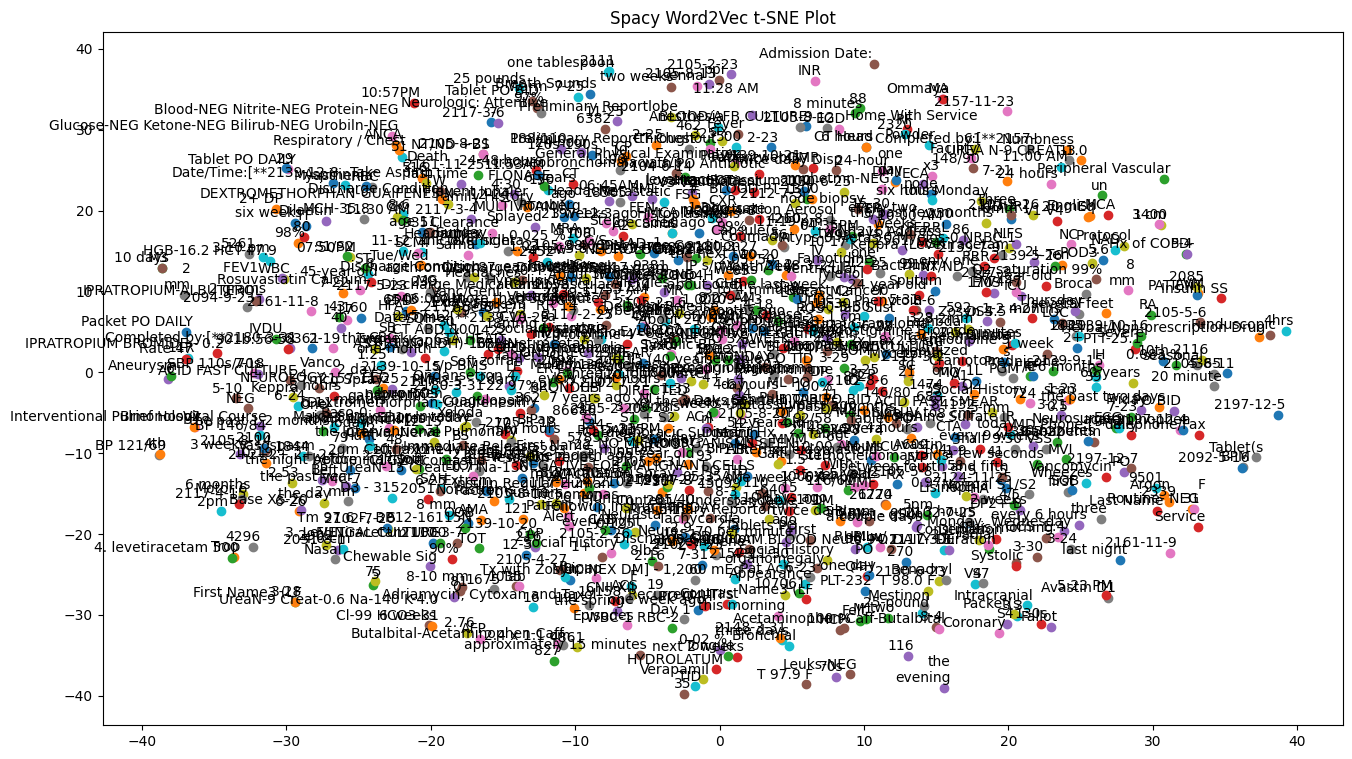

In [44]:
tsne_plot(spacy_w2v, "Spacy Word2Vec t-SNE Plot")

In [35]:
len(spacy_w2v.wv.key_to_index.keys())

1006

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


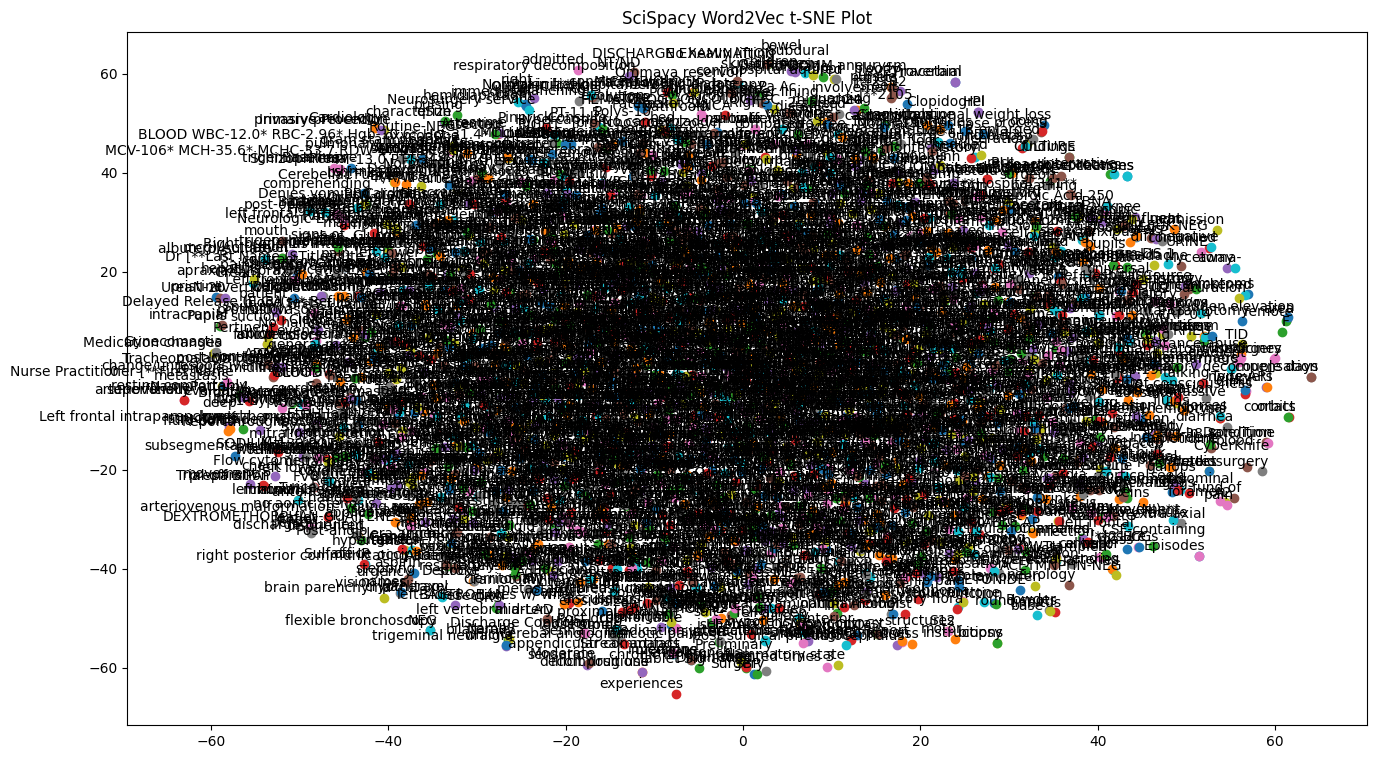

In [45]:
tsne_plot(scispacy_w2v, "SciSpacy Word2Vec t-SNE Plot")

In [37]:
len(scispacy_w2v.wv.key_to_index.keys())

3007

In [38]:
spacy_keys = set(spacy_w2v.wv.key_to_index.keys())
scispacy_keys = set(scispacy_w2v.wv.key_to_index.keys())

common_keys = spacy_keys.intersection(scispacy_keys)

common_keys

{'A1',
 'A2',
 'ACE',
 'ACID FAST CULTURE',
 'ACID FAST SMEAR',
 'ACS',
 'AFP',
 'AMA',
 'ANCA',
 'ASA',
 'AVM',
 'Alert',
 'Amlodipine 5',
 'AnGap-12',
 'Appearance',
 'Argon',
 'Aspirin',
 'Autoimmune',
 'Avastin D1',
 'BIL',
 'BIPAP',
 'BLOOD/FUNGAL CULTURE',
 'BP',
 'BPM',
 'BS',
 'Bactrim',
 'Benadryl',
 'BiPap',
 'Bipap',
 'Brain',
 'Breast Cancer',
 'Breath Sounds',
 'Brief Hospital Course',
 'C1-T2',
 'CAD',
 'CAP',
 'CBC',
 'CHF',
 'CI',
 'CK',
 'CNII-XII',
 'COPD',
 'CP',
 'CRP',
 'CSF',
 'CT',
 'CT Chest',
 'CTA',
 'CXR',
 'Cardiac',
 'Cardiothoracic Surgery',
 'Clearance',
 'Coagulopathy',
 'Constipation',
 'Contrast',
 'Coumadin',
 'Craniotomy',
 'CyberKnife',
 'D15',
 'DAILY',
 'DEXTROMETHORPHAN-GUAIFENESIN',
 'DIRECTED',
 'DM',
 'DMII',
 'DP',
 'DRS',
 'DSS',
 'Delayed Release',
 'Denies',
 'Diarrhea',
 'Dilantin',
 'Discharge Condition',
 'Discharge Disposition',
 'Discharge Medications',
 'Docusate',
 'ECA',
 'ECG',
 'ED',
 'EEG',
 'EGD',
 'EMS',
 'EOM',
 'ER+',
 'Engl

In [39]:
spacy_w2v.wv.most_similar('ICU')

[('7447', 0.334592342376709),
 ('MICU', 0.2862762212753296),
 ('Tablet(s', 0.26245033740997314),
 ('Dextromethorphan-Guaifenesin', 0.2613799273967743),
 ('10:00 AM\nWith:', 0.2470952272415161),
 ('41', 0.23420687019824982),
 ('Ventricular', 0.23152616620063782),
 ('Keppra (Levetiracetam', 0.22901614010334015),
 ('Intracranial', 0.22889864444732666),
 ('5-4', 0.22882317006587982)]

In [40]:
scispacy_w2v.wv.most_similar('ICU')

[('evidence', 0.32620295882225037),
 ('PCR', 0.3113473057746887),
 ('mild vasopsasm', 0.30280187726020813),
 ('surgeries', 0.2942447066307068),
 ('Bipolar disorder', 0.2922803461551666),
 ('Taxol', 0.2915702164173126),
 ('Capsule Sig', 0.2909473478794098),
 ('drain', 0.281598836183548),
 ('Temperature', 0.2744073271751404),
 ('intraparenchymal', 0.273619145154953)]

In [41]:
# Using clinicalBERT library to identify most similar notes containing 'ICU' in entire dataset from the original query, not just sample size.

from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

filtered_df = df[df['TEXT'].str.contains('ICU', case=False, na=False)]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [42]:
clinicalBERT_embeddings = []

for text in filtered_df['TEXT']:
    tokens = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**tokens)

    embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    clinicalBERT_embeddings.append(embedding)

clinicalBERT_embeddings = np.vstack(clinicalBERT_embeddings)

similarity_matrix = cosine_similarity(clinicalBERT_embeddings)

np.fill_diagonal(similarity_matrix, 0)

max_sim_index = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)

note_1_index, note_2_index = max_sim_index

note_1_text = filtered_df.iloc[note_1_index]['TEXT']
note_2_text = filtered_df.iloc[note_2_index]['TEXT']

In [43]:
print(f"""
The two most similar notes are at positions: {note_1_index} and {note_2_index} in the filtered DataFrame.

*****************************************************************************************************************************

Text of the first note:
{note_1_text}

*****************************************************************************************************************************

Text of the second note:
{note_2_text}
""")


The two most similar notes are at positions: 220 and 232 in the filtered DataFrame.

*****************************************************************************************************************************

Text of the first note:
Admission Date:  [**2109-7-26**]              Discharge Date:   [**2109-8-5**]

Date of Birth:  [**2044-3-27**]             Sex:   F

Service: NEUROSURGERY

Allergies:
Codeine

Attending:[**First Name3 (LF) 78**]
Chief Complaint:
Headache went to opthamologist and found to SAH

Major Surgical or Invasive Procedure:
Coiling of P-Comm Aneurysm

History of Present Illness:
65F who reports having R sided HA and pain behind eye for  past
week now progressing to left frontal region. Was seen by
opthomologist today and sent for a Head CT in which there was
SAH. She was then transferred to [**Hospital1 18**] for further evaluation.

Past Medical History:
None

Social History:
smoke 16 cigarettes/day

Family History:
Not available

Physical Exam:
T:97.1 BP:118/6